In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from pytorch_msssim import ms_ssim

In [5]:
LATENT_DIM = 256
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
IMAGE_SIZE = (300, 300)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "../continuum_data_subset"

In [6]:
class FitsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        with fits.open(file_path) as hdul:
            image_data = hdul[0].data

        image_data = np.squeeze(image_data)[0]
        image_data = np.nan_to_num(image_data)
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

        image = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        return image

In [7]:
transform = Resize(IMAGE_SIZE, antialias=True)
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.fits')]
dataset = FitsDataset(file_list, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *IMAGE_SIZE)
            conv_out = self.encoder_conv(dummy_input)
            self.flattened_size = conv_out.numel()
            self.conv_shape = conv_out.shape

        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, latent_dim),
            nn.ReLU()
        )

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, self.flattened_size),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, self.conv_shape[1:]),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder_fc(self.encoder_conv(x))
        decoded = self.decoder_conv(self.decoder_fc(encoded))
        return decoded, encoded

In [9]:
model = Autoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler()

/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [10]:
def train_autoencoder(model, dataloader, epochs, criterion, optimizer, scheduler):
    model.train()
    mse_losses, ssim_scores = [], []
    epoch_samples = {}

    for epoch in range(epochs):
        total_loss, total_ssim = 0, 0
        for batch in dataloader:
            batch = batch.to(DEVICE)

            optimizer.zero_grad()
            with torch.autocast("cuda"):
                batch = batch.to(torch.float32)
                reconstructed, _ = model(batch)
                reconstructed = torch.nn.functional.interpolate(reconstructed, size=IMAGE_SIZE, mode='bilinear', align_corners=False)

                loss_mse = criterion(reconstructed, batch)
                loss_ssim = 1 - ms_ssim(reconstructed, batch, data_range=1.0)
                loss = loss_mse + loss_ssim

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss_mse.item()
            total_ssim += (1 - loss_ssim).item()

        mse_losses.append(total_loss / len(dataloader))
        ssim_scores.append(total_ssim / len(dataloader))
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse_losses[-1]:.6f}, SSIM: {ssim_scores[-1]:.6f}")

        if (epoch + 1) % 5 == 0:
            epoch_samples[epoch] = batch.cpu()

    return mse_losses, ssim_scores, epoch_samples

In [11]:
def visualize_epoch_comparison(model, epoch_samples):
    fig, axes = plt.subplots(len(epoch_samples), 3, figsize=(12, 4 * len(epoch_samples)))
    model.eval()

    with torch.no_grad():
        for i, (epoch, batch) in enumerate(epoch_samples.items()):
            batch = batch.to(DEVICE)
            reconstructed, _ = model(batch)
            reconstructed = torch.nn.functional.interpolate(reconstructed, size=IMAGE_SIZE, mode='bilinear', align_corners=False)

            error_map = torch.abs(batch - reconstructed).cpu().numpy()

            axes[i, 0].imshow(batch[0, 0].cpu().numpy(), cmap='gray')
            axes[i, 0].set_title(f"Original (Epoch {epoch+1})")

            axes[i, 1].imshow(reconstructed[0, 0].cpu().numpy(), cmap='gray')
            axes[i, 1].set_title(f"Reconstructed (Epoch {epoch+1})")

            axes[i, 2].imshow(error_map[0, 0], cmap='inferno')
            axes[i, 2].set_title(f"Error Map (Epoch {epoch+1})")

            for ax in axes[i]:
                ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_loss_curves(mse_losses, ssim_scores):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(mse_losses, label="MSE Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("MSE Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ssim_scores, label="SSIM Score", color='orange', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("SSIM Score")
    plt.title("SSIM Curve")
    plt.legend()

    plt.show()

In [12]:
def main():
    mse_losses, ssim_scores, epoch_samples = train_autoencoder(model, dataloader, EPOCHS, criterion, optimizer, scheduler)

    visualize_epoch_comparison(model, epoch_samples)
    plot_loss_curves(mse_losses, ssim_scores)

/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/50, MSE: 0.139526, SSIM: 0.605906
Epoch 2/50, MSE: 0.012736, SSIM: 0.646727
Epoch 3/50, MSE: 0.009390, SSIM: 0.720252
Epoch 4/50, MSE: 0.007880, SSIM: 0.742208
Epoch 5/50, MSE: 0.004547, SSIM: 0.856821
Epoch 6/50, MSE: 0.002916, SSIM: 0.901585
Epoch 7/50, MSE: 0.002186, SSIM: 0.922520
Epoch 8/50, MSE: 0.001657, SSIM: 0.933160
Epoch 9/50, MSE: 0.001230, SSIM: 0.942730
Epoch 10/50, MSE: 0.000954, SSIM: 0.949616
Epoch 11/50, MSE: 0.000898, SSIM: 0.954168
Epoch 12/50, MSE: 0.000661, SSIM: 0.959979
Epoch 13/50, MSE: 0.000573, SSIM: 0.962799
Epoch 14/50, MSE: 0.000537, SSIM: 0.964191
Epoch 15/50, MSE: 0.000463, SSIM: 0.967933
Epoch 16/50, MSE: 0.000445, SSIM: 0.968504
Epoch 17/50, MSE: 0.000375, SSIM: 0.969851
Epoch 18/50, MSE: 0.000325, SSIM: 0.975406
Epoch 19/50, MSE: 0.000336, SSIM: 0.974269
Epoch 20/50, MSE: 0.000313, SSIM: 0.976752
Epoch 21/50, MSE: 0.000274, SSIM: 0.978344
Epoch 22/50, MSE: 0.000275, SSIM: 0.980974
Epoch 23/50, MSE: 0.000235, SSIM: 0.981133
Epoch 24/50, MSE: 0.

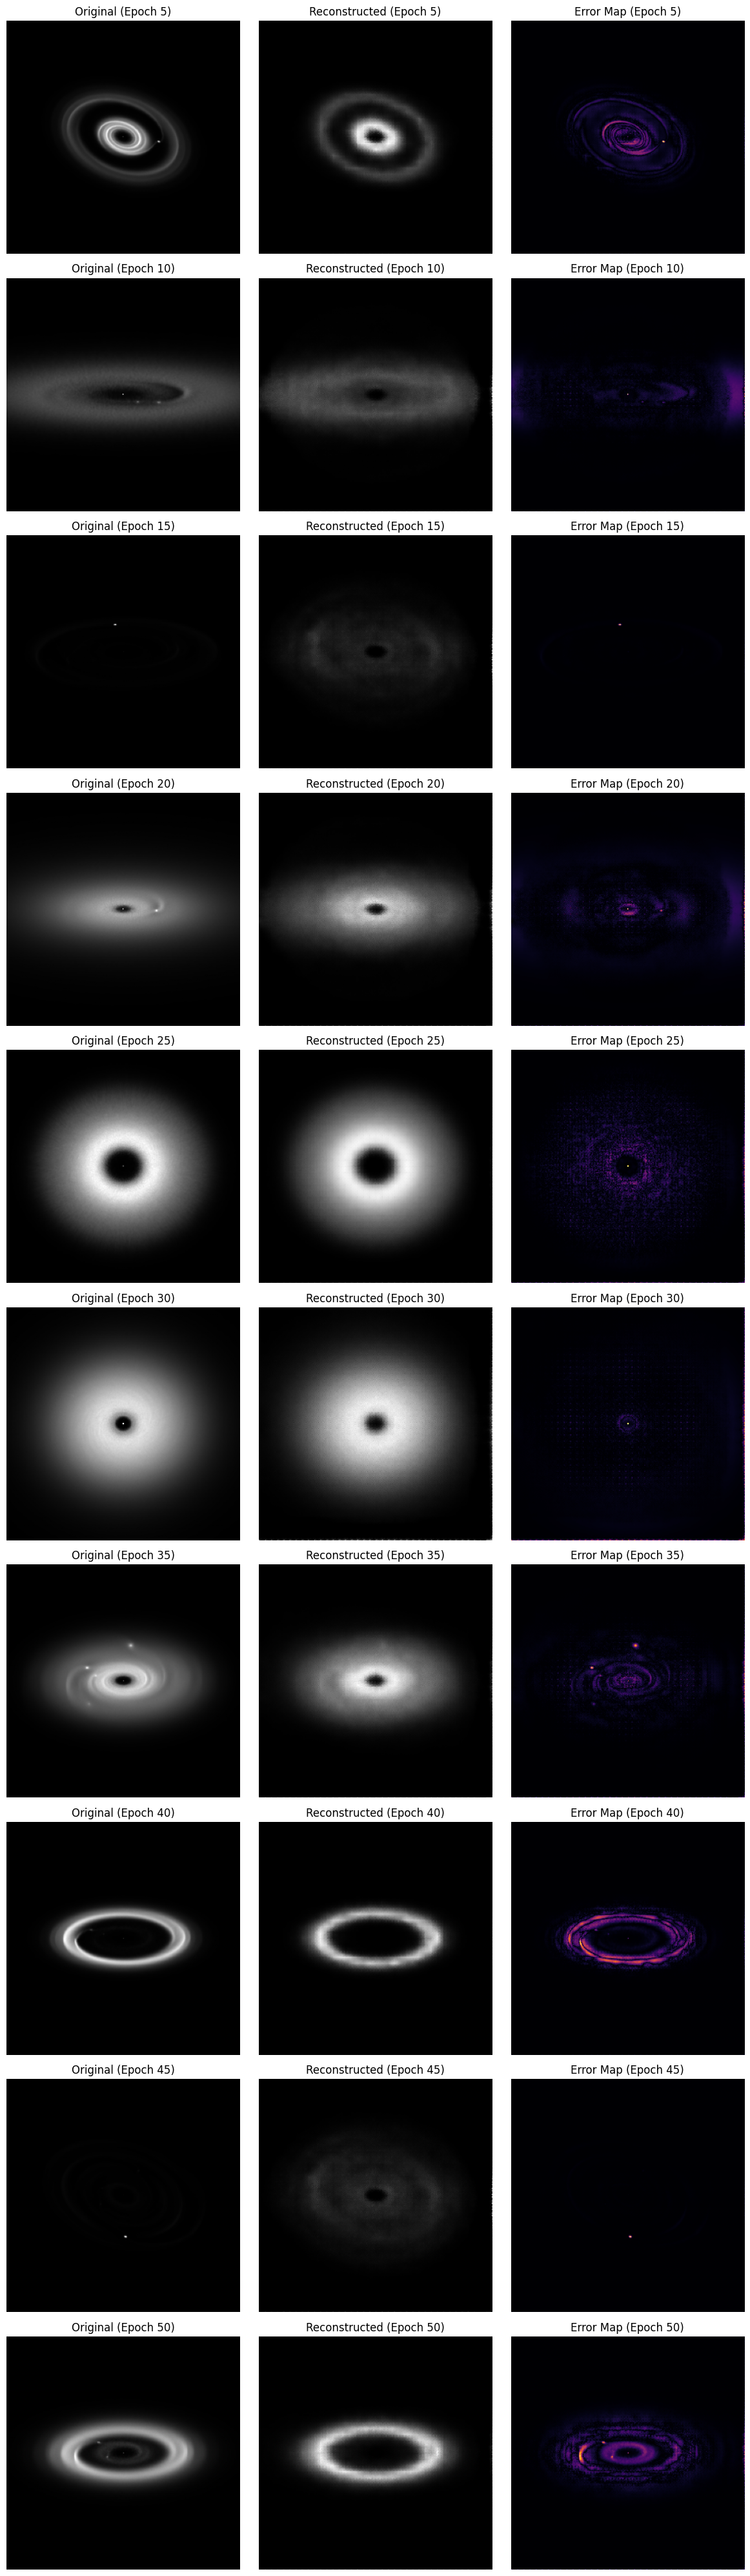

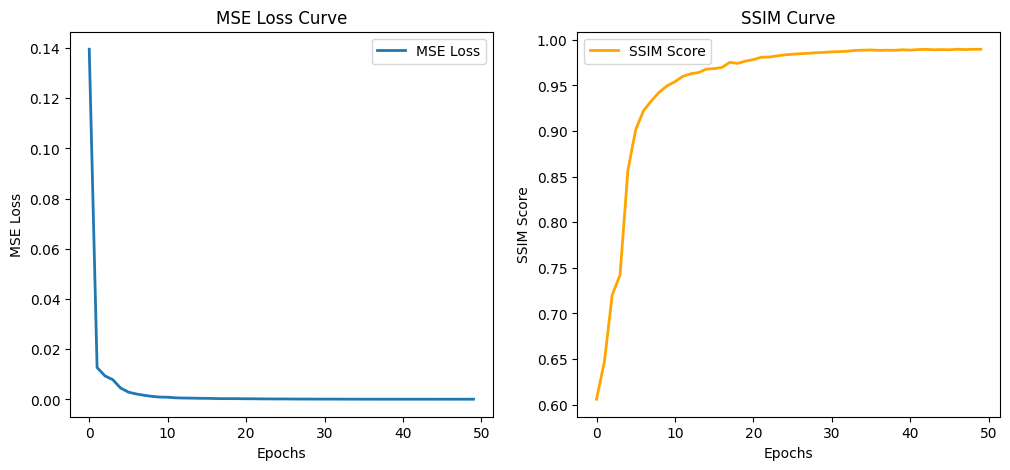

In [13]:
if __name__ == "__main__":
    main()

/Users/Arnav/Documents/EXXA-Evaluation-Test/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/50, MSE: 0.154999, SSIM: 0.597943
Epoch 2/50, MSE: 0.020900, SSIM: 0.672865
Epoch 3/50, MSE: 0.010144, SSIM: 0.715393
Epoch 4/50, MSE: 0.009974, SSIM: 0.706074
Epoch 5/50, MSE: 0.009893, SSIM: 0.740103
Epoch 6/50, MSE: 0.009039, SSIM: 0.757496
Epoch 7/50, MSE: 0.006603, SSIM: 0.807795
Epoch 8/50, MSE: 0.005008, SSIM: 0.840734
Epoch 9/50, MSE: 0.004397, SSIM: 0.855817
Epoch 10/50, MSE: 0.004345, SSIM: 0.852970
Epoch 11/50, MSE: 0.003970, SSIM: 0.867152
Epoch 12/50, MSE: 0.004128, SSIM: 0.867474
Epoch 13/50, MSE: 0.004195, SSIM: 0.871509
Epoch 14/50, MSE: 0.003401, SSIM: 0.884943
Epoch 15/50, MSE: 0.002962, SSIM: 0.903227
Epoch 16/50, MSE: 0.002522, SSIM: 0.918588
Epoch 17/50, MSE: 0.002197, SSIM: 0.927587
Epoch 18/50, MSE: 0.002151, SSIM: 0.922109
Epoch 19/50, MSE: 0.002337, SSIM: 0.922498
Epoch 20/50, MSE: 0.001846, SSIM: 0.936948
Epoch 21/50, MSE: 0.001640, SSIM: 0.943223
Epoch 22/50, MSE: 0.001299, SSIM: 0.951304
Epoch 23/50, MSE: 0.000802, SSIM: 0.957941
Epoch 24/50, MSE: 0.

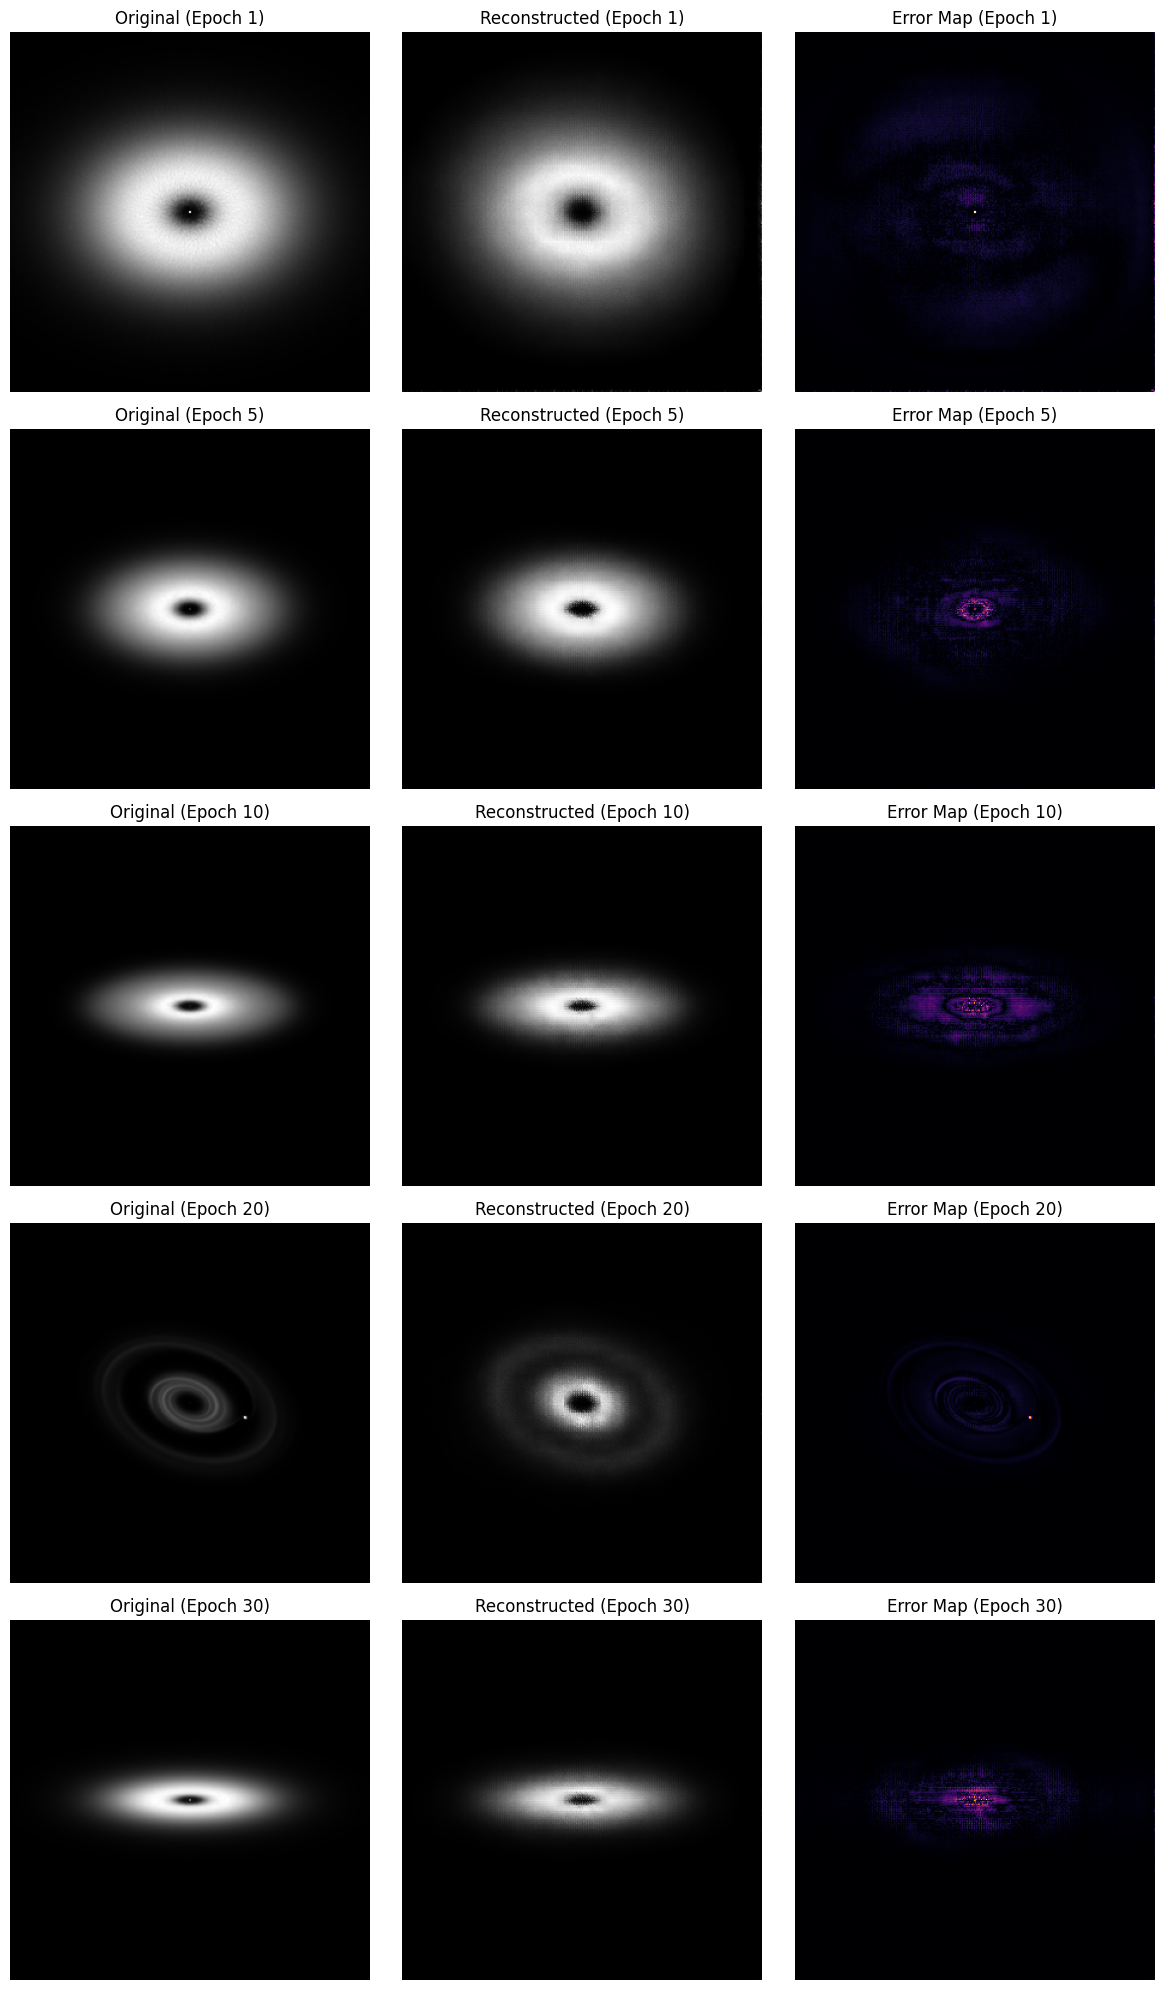

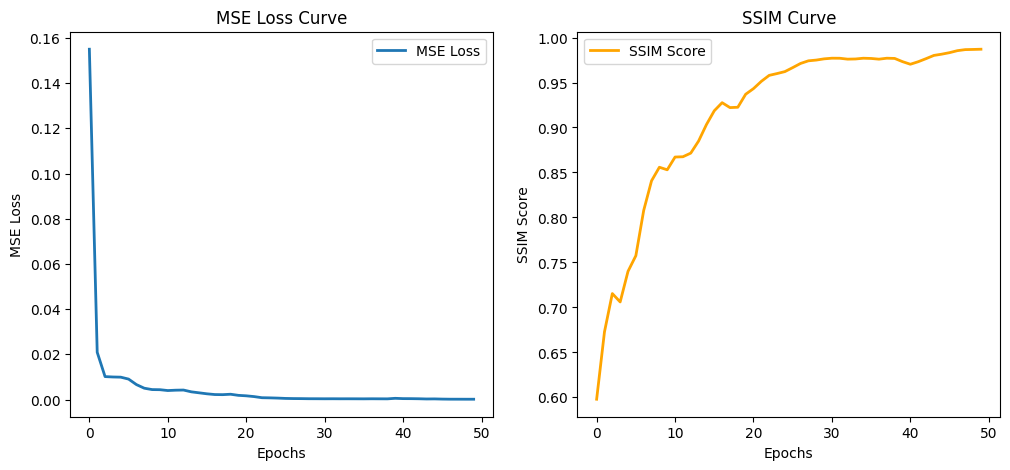

In [19]:
if __name__ == "__main__":
    main()